In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install required libraries
!pip install wordcloud textstat

import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
from textstat.textstat import textstat
import re

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')

# Set the path to your data
base_path = "/content/drive/MyDrive/Capstone/json_output/split_colab"

# Function to read JSON file
def read_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

# Function to read MD file
def read_md(file_path):
    with open(file_path, 'r') as f:
        return f.read()

# Function to count words in text
def word_count(text):
    return len(text.split())

# Function to calculate readability score
def calculate_readability(text):
    return textstat.flesch_kincaid_grade(text)



Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 46.0 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


TypeError: unsupported operand type(s) for +=: 'int' and 'dict'

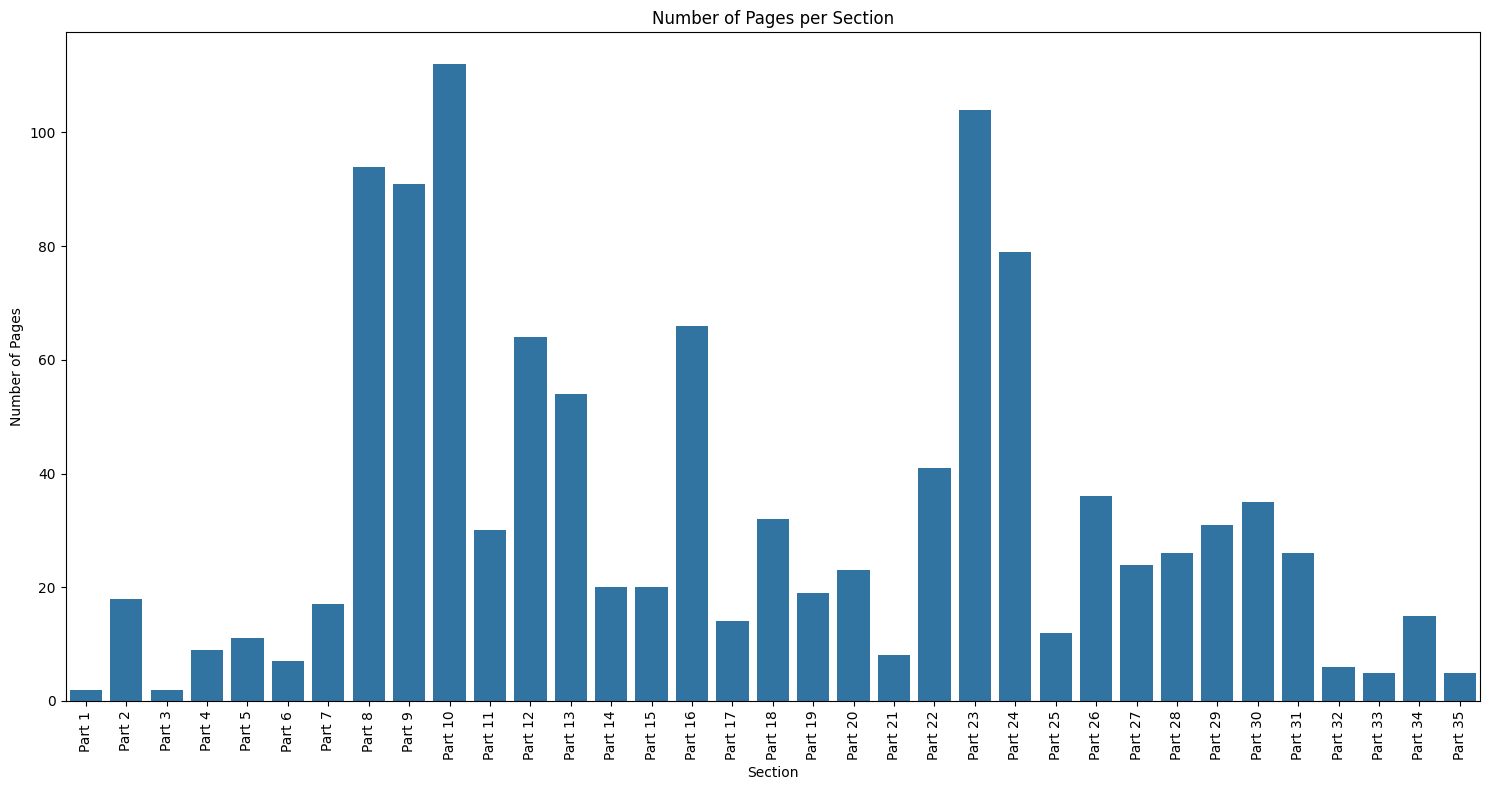

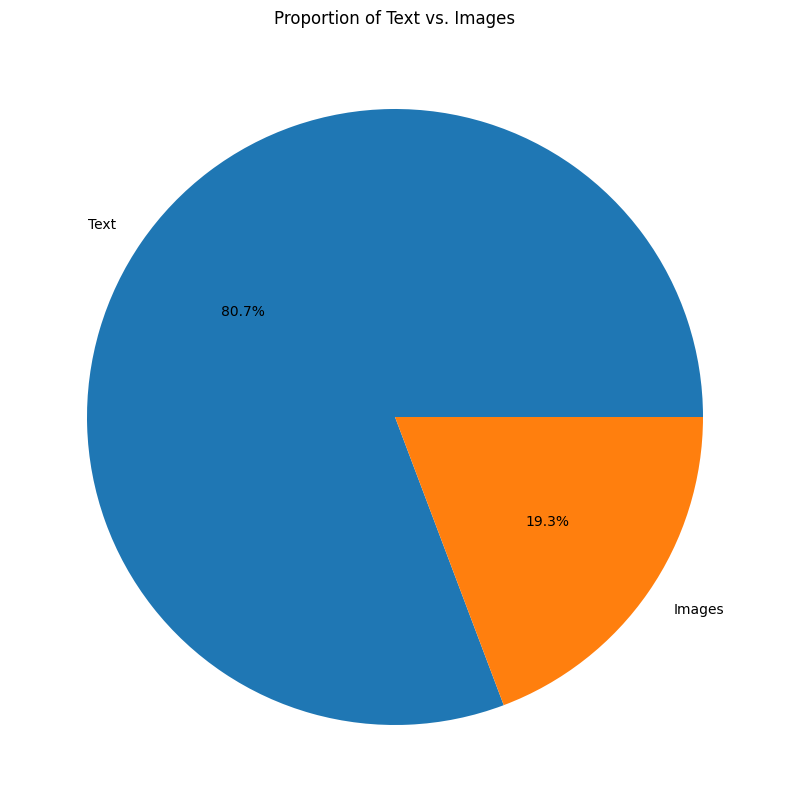

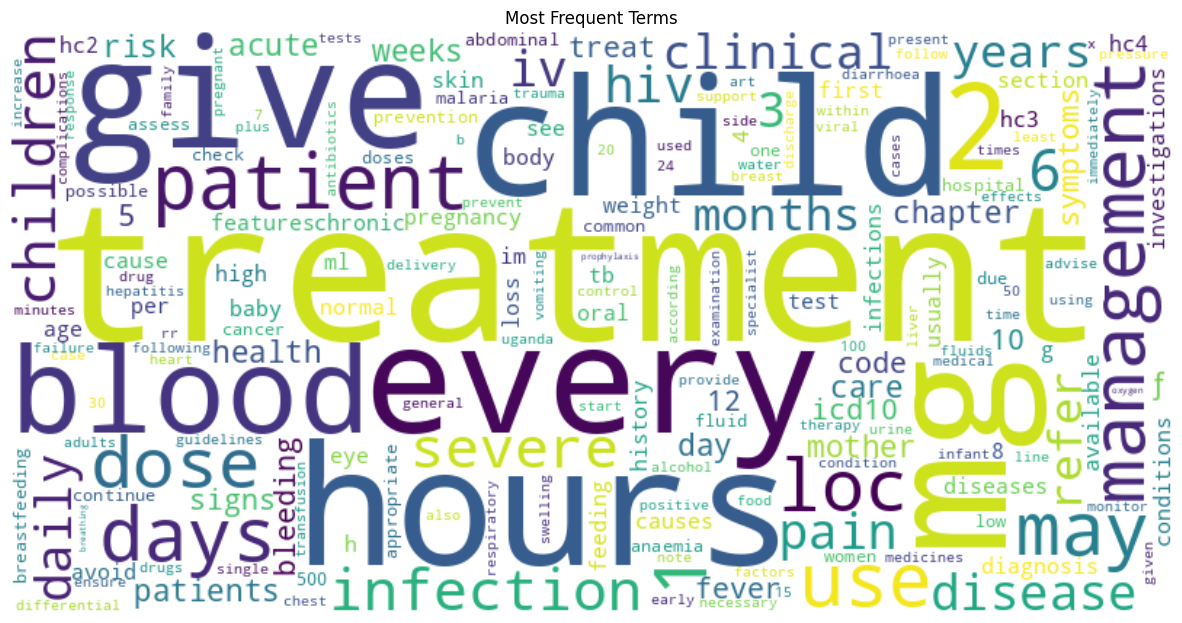

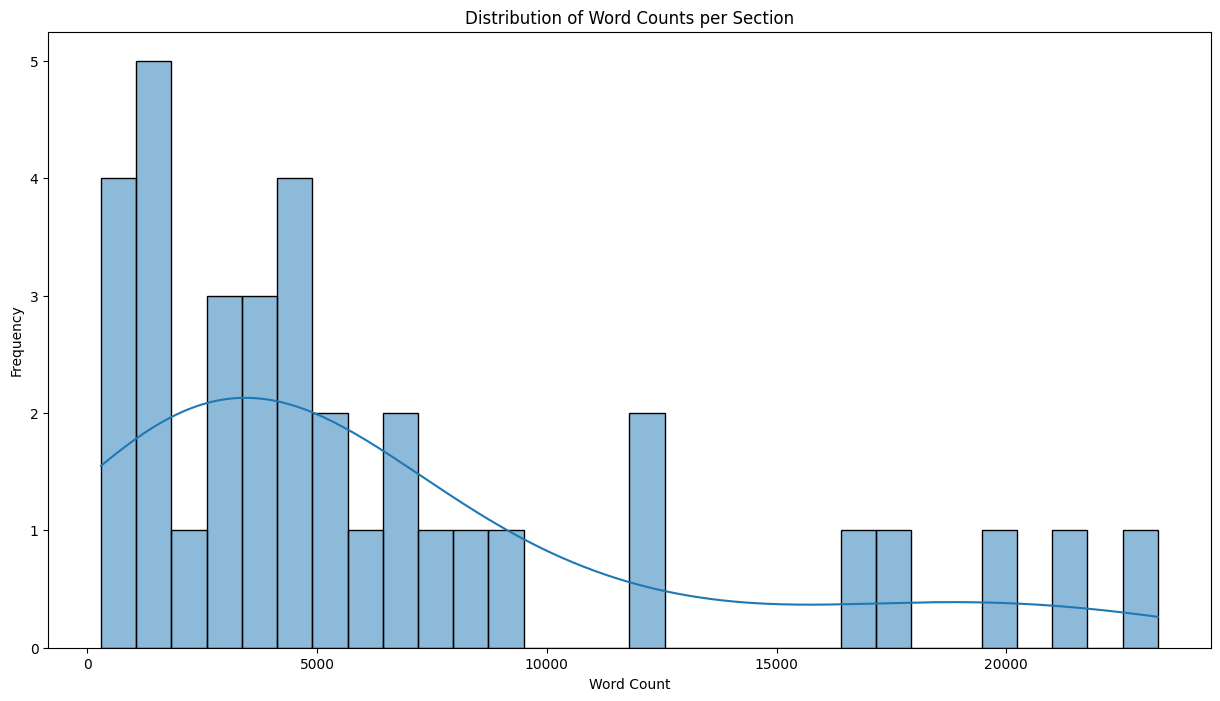

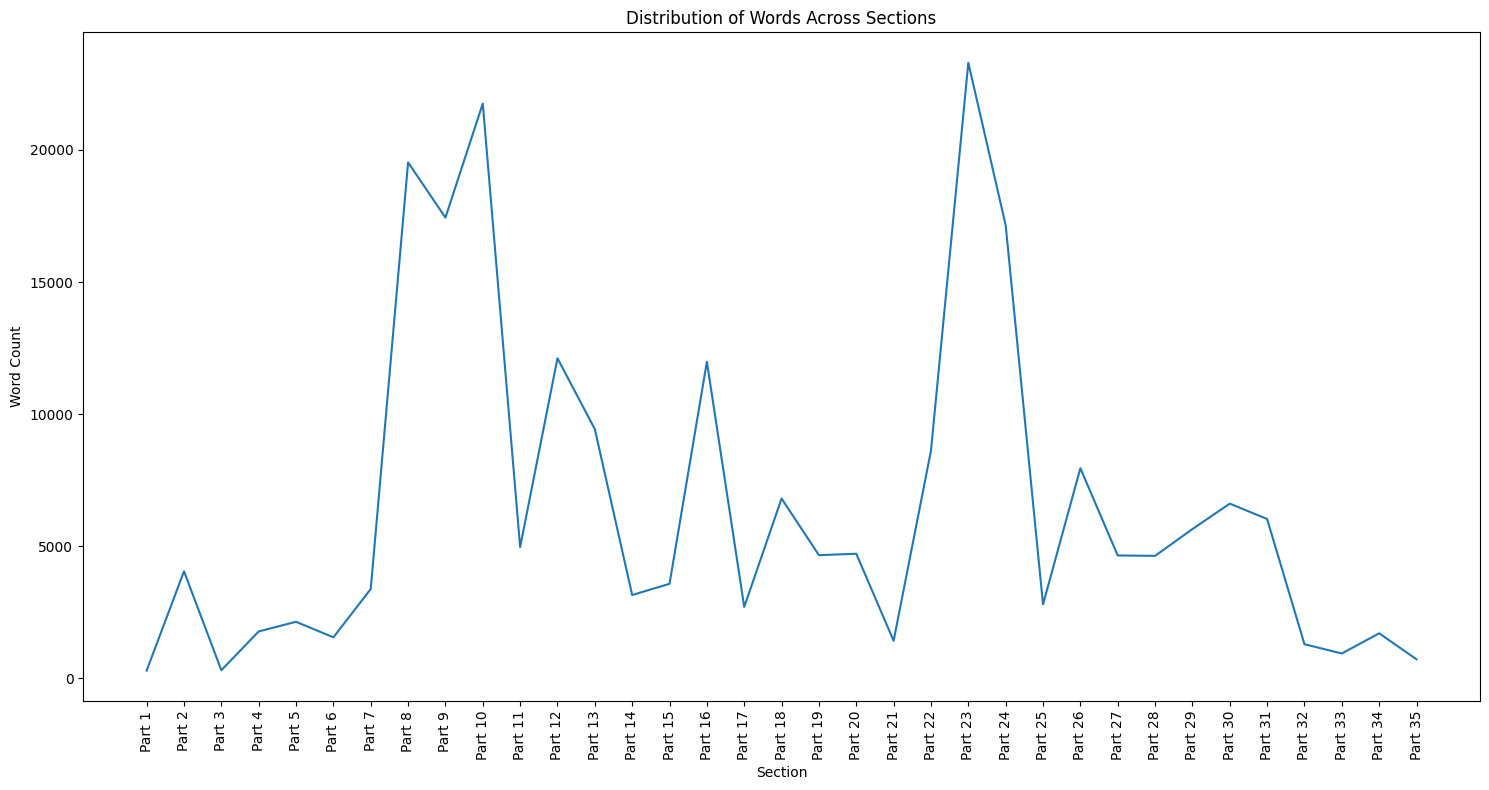

<Figure size 1500x800 with 0 Axes>

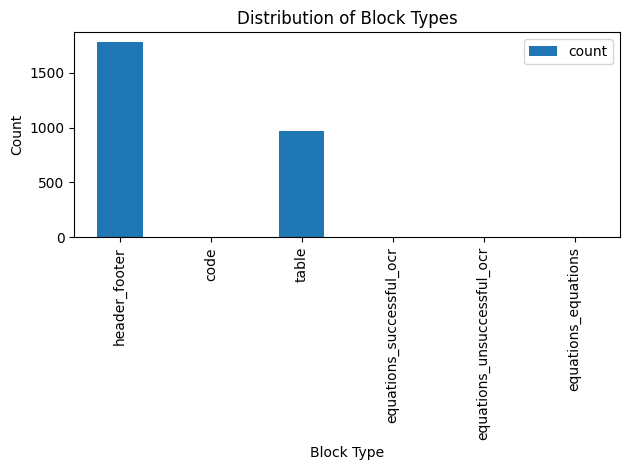

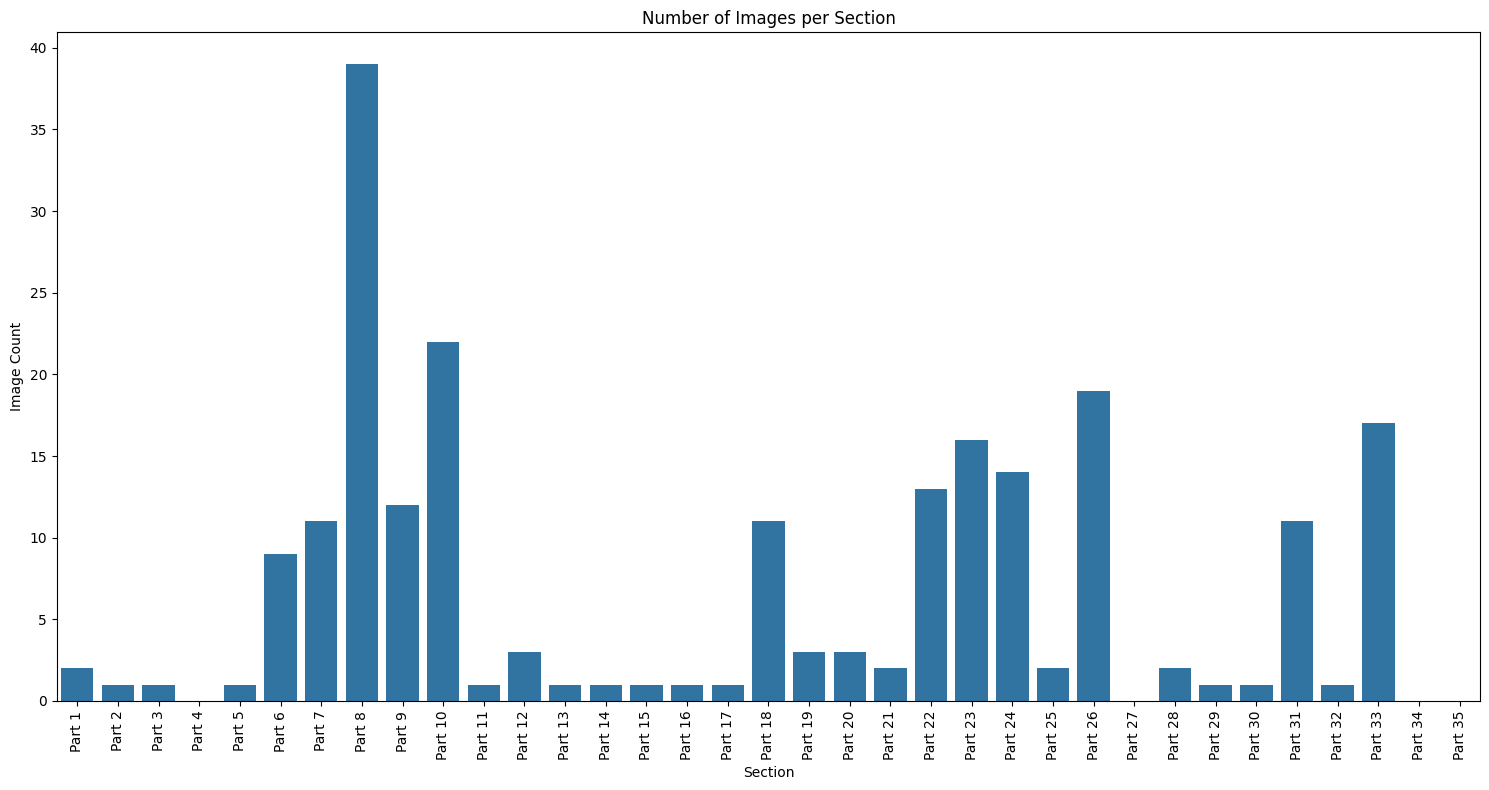

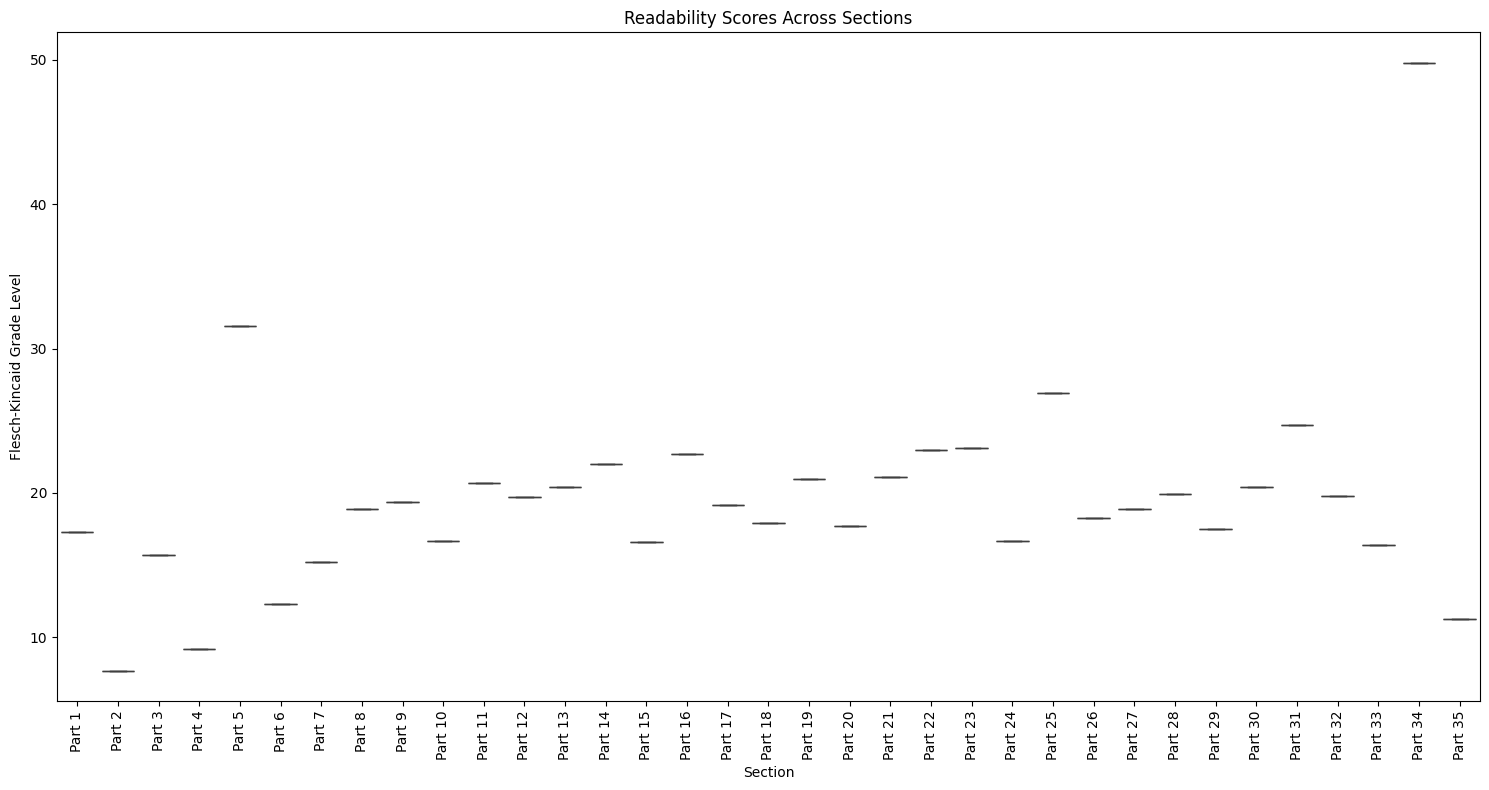

Summary Statistics for Sections:
       page_count  readability_score
count   35.000000          35.000000
mean    33.085714          19.705714
std     30.709619           6.950706
min      2.000000           7.700000
25%     11.500000          16.700000
50%     23.000000          19.200000
75%     38.500000          21.050000
max    112.000000          49.800000

Summary Statistics for Word Counts:
         word_count
count     35.000000
mean    6567.542857
std     6317.353883
min      297.000000
25%     1960.500000
50%     4653.000000
75%     8285.500000
max    23297.000000

Summary Statistics for Image Data:
       image_count
count    35.000000
mean      6.371429
std       8.571793
min       0.000000
25%       1.000000
50%       2.000000
75%      11.000000
max      39.000000


In [2]:
# Initialize data structures
section_data = []
all_text = ""
word_counts = []
image_data = []
block_types = Counter()

# Process each part
for i in range(1, 36):
    part_path = os.path.join(base_path, f"split_Part{i}")
    json_file = os.path.join(part_path, f"split_Part{i}_meta.json")
    md_file = os.path.join(part_path, f"split_Part{i}.md")

    if os.path.exists(json_file) and os.path.exists(md_file):
        json_data = read_json(json_file)
        md_text = read_md(md_file)

        # Content Distribution
        page_count = json_data.get('pages', 0)
        section_data.append({'section': f'Part {i}', 'page_count': page_count})

        # Text Analysis
        all_text += md_text
        word_counts.append({'section': f'Part {i}', 'word_count': word_count(md_text)})

        # Structure Analysis
        block_stats = json_data.get('block_stats', {})
        for block, count in block_stats.items():
            if isinstance(count, dict):
                for sub_block, sub_count in count.items():
                    block_types[f"{block}_{sub_block}"] += sub_count
            else:
                block_types[block] += count

        # Image Analysis
        image_count = len([f for f in os.listdir(part_path) if f.endswith('.png')])
        image_data.append({'section': f'Part {i}', 'image_count': image_count})

        # Readability Analysis
        readability_score = calculate_readability(md_text)
        section_data[-1]['readability_score'] = readability_score


# Create DataFrames
df_sections = pd.DataFrame(section_data)
df_word_counts = pd.DataFrame(word_counts)
df_image_data = pd.DataFrame(image_data)

# 4.1 Content Distribution
plt.figure(figsize=(15, 8))
sns.barplot(x='section', y='page_count', data=df_sections)
plt.title('Number of Pages per Section')
plt.xlabel('Section')
plt.ylabel('Number of Pages')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Pie chart of text vs. images
total_pages = df_sections['page_count'].sum()
total_images = df_image_data['image_count'].sum()
plt.figure(figsize=(10, 10))
plt.pie([total_pages - total_images, total_images], labels=['Text', 'Images'], autopct='%1.1f%%')
plt.title('Proportion of Text vs. Images')
plt.show()

# 4.2 Text Analysis
# Word cloud
stop_words = set(stopwords.words('english'))
words = [word.lower() for word in nltk.word_tokenize(all_text) if word.isalnum()]
word_freq = Counter(word for word in words if word not in stop_words)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Terms')
plt.show()

# Histogram of word counts
plt.figure(figsize=(15, 8))
sns.histplot(df_word_counts['word_count'], bins=30, kde=True)
plt.title('Distribution of Word Counts per Section')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

# Line graph of word counts across sections
plt.figure(figsize=(15, 8))
sns.lineplot(x='section', y='word_count', data=df_word_counts)
plt.title('Distribution of Words Across Sections')
plt.xlabel('Section')
plt.ylabel('Word Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 4.3 Structure Analysis
# Bar chart of block types
plt.figure(figsize=(15, 8))
block_df = pd.DataFrame.from_dict(block_types, orient='index', columns=['count'])
block_df.plot(kind='bar')
plt.title('Distribution of Block Types')
plt.xlabel('Block Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 4.4 Image Analysis
# Bar chart of image count per section
plt.figure(figsize=(15, 8))
sns.barplot(x='section', y='image_count', data=df_image_data)
plt.title('Number of Images per Section')
plt.xlabel('Section')
plt.ylabel('Image Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 4.5 Readability Analysis
# Box plot of readability scores
plt.figure(figsize=(15, 8))
sns.boxplot(x='section', y='readability_score', data=df_sections)
plt.title('Readability Scores Across Sections')
plt.xlabel('Section')
plt.ylabel('Flesch-Kincaid Grade Level')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary Statistics for Sections:")
print(df_sections.describe())
print("\nSummary Statistics for Word Counts:")
print(df_word_counts.describe())
print("\nSummary Statistics for Image Data:")
print(df_image_data.describe())